<a href="https://colab.research.google.com/github/SynolaAlbuquerque/stock-scraper/blob/main/Britannia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
#@title Installing libraries & packages
!pip install yfinance textblob vaderSentiment lazypredict scikit-learn pandas numpy matplotlib seaborn --quiet

import re
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from lazypredict.Supervised import LazyRegressor, LazyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [85]:
with open("/content/parsed_headlines_nicely_formatted.txt", 'r', encoding='utf-8') as f:
    Britannia_headlines_string = f.read()

    HEADLINES = Britannia_headlines_string

In [86]:
print(HEADLINES)

1. Britannia Industries share price: Neutral on Britannia Industries, target price Rs 3830: Motilal Oswal
Source: economictimes.indiatimes.com
Published on: 09 Feb 2021, 03:44 AM

2. Britannia Industries Rating: buy- Sales growth in quarter was below par
Source: financialexpress.com
Published on: 14 Feb 2021, 09:30 PM

3. Hudbay Announces Fourth Quarter and Full Year 2020 Results and Provides Annual Guidance
Source: benzinga.com
Published on: 18 Feb 2021, 10:55 PM

4. Hudbay Announces Fourth Quarter and Full Year 2020 Results and Provides Annual Guidance
Source: marketscreener.com
Published on: 18 Feb 2021, 10:56 PM

5. britannia share price: Buy Britannia Industries, target price Rs 4575: Motilal Oswal
Source: economictimes.indiatimes.com
Published on: 07 Apr 2021, 03:23 AM

6. Indian shares inch higher, blue-chip earnings in focus
Source: financialpost.com
Published on: 27 Apr 2021, 04:03 AM

7. Shares inch higher, blue-chip earnings in focus
Source: thehindubusinessline.com
Publishe

In [87]:
import re
import pandas as pd
import datetime

# --- SETTINGS ---
KEYWORDS = [
    "profit", "revenue", "earnings", "margin", "growth", "decline", "loss", "rise", "fall",
    "outperform", "underperform", "quarterly results", "Q1", "Q2", "Q3", "Q4", "EPS",
    "dividend", "bonus", "buyback", "debentures", "downgrade", "upgrade",
    "acquisition", "merger", "joint venture", "stake sale", "investment", "expansion",
    "restructuring", "partnership", "collaboration", "digital transformation", "demerger",
    "subsidiary", "capacity expansion", "manufacturing plant", "new facility",
    "CEO", "CFO", "resignation", "appointment", "leadership change", "management reshuffle",
    "Varun Berry", "Rajneet Kohli",
    "product launch", "campaign", "brand identity", "Good Day", "Dairy", "Cheese",
    "biscuits", "FMCG products", "new variant",
    "target price", "share price", "buy", "sell", "hold recommendation", "brokerage call",
    "stock rating", "stock rally", "stock dip", "market cap", "investor confidence",
    "analyst view", "inflation", "commodity cost", "input cost", "raw material price",
    "rural demand", "urban demand", "consumption slowdown", "FMCG sector",
    "competition", "Reliance FMCG", "ITC", "HUL", "demand recovery", "market sentiment",
    "economy", "policy", "interest rate", "RBI", "price correction", "bearish", "bullish",
    "margin pressure", "sales slump", "costly commodities"
]

KEYWORD_BOOST = 1  # Multiply sentiment score if keyword present
USE_3DAYS = True
USE_5DAYS = True
STOCK = 'BRITANNIA.NS'
START_DATE = '2021-01-03'
END_DATE = datetime.datetime.today().strftime('%Y-%m-%d')


# --- PARSE HEADLINES FUNCTION ---
def parse_headlines(text):
    lines = text.strip().split('\n')
    records = []
    buff, date, source = "", None, None

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Detect start of a new headline (e.g., "1. Britannia ...")
        if re.match(r'^\d+\.', line):
            # Save previous record before starting a new one
            if buff and date is not None:
                records.append({'date': date, 'headline': buff.strip(), 'source': source})
            buff = re.sub(r'^\d+\.\s*', '', line).strip()
            date = None
            source = None  # Reset source for the new headline

        elif line.startswith('Source:'):
            match = re.match(r'Source:\s*(.*)', line)
            if match:
                source = match.group(1).strip()

        elif line.startswith('Published on:'):
            match = re.search(r'(\d{2} \w{3} \d{4})', line)
            if match:
                date = pd.to_datetime(match.group(1), format='%d %b %Y')

        # Handle continuation lines (not source/published lines)
        elif not line.startswith('Source:') and not line.startswith('Published on:'):
            buff += " " + line.strip()

    # Add the last record
    if buff and date is not None:
        records.append({'date': date, 'headline': buff.strip(), 'source': source})

    return pd.DataFrame(records)


# --- RUN PARSER ---
# Replace HEADLINES with the variable or text containing your Britannia headlines file
news_df = parse_headlines(HEADLINES)

# Ensure the DataFrame has proper columns
news_df = news_df.dropna(subset=['date', 'source']).sort_values('date').reset_index(drop=True)

print(f"Parsed {len(news_df)} Britannia headlines with dates and sources.")
display(news_df.head())


Parsed 298 Britannia headlines with dates and sources.


,date,headline,source
0,2021-02-09,Britannia Industries share price: Neutral on B...,economictimes.indiatimes.com
1,2021-02-14,Britannia Industries Rating: buy- Sales growth...,financialexpress.com
2,2021-02-18,Hudbay Announces Fourth Quarter and Full Year ...,benzinga.com
3,2021-02-18,Hudbay Announces Fourth Quarter and Full Year ...,marketscreener.com
4,2021-04-07,britannia share price: Buy Britannia Industrie...,economictimes.indiatimes.com


In [88]:
analyzer = SentimentIntensityAnalyzer()

def calc_sentiments(row):
    text = row['headline']
    vs = analyzer.polarity_scores(text)
    vader_score = vs['compound']
    tb_score = TextBlob(text).sentiment.polarity
    amplify = any(kw.lower() in text.lower() for kw in KEYWORDS)
    boost = KEYWORD_BOOST if amplify else 1.0
    vader_score *= boost
    tb_score *= boost
    return pd.Series({'vader': vader_score, 'textblob': tb_score})

news_df[['vader', 'textblob']] = news_df.apply(calc_sentiments, axis=1)
news_df['sentiment'] = (news_df['vader'] + news_df['textblob'])/2


In [89]:
df = yf.download(STOCK, start=START_DATE, end=END_DATE)

# Flatten multi-level columns if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])

# Ensure consistent columns
expected_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
if "Adj Close" in df.columns:
    expected_cols.append("Adj Close")

df = df[expected_cols]

# Rename for merge
df = df.rename(columns={'Date': 'date'})

# Ensure same dtype for merge
df['date'] = pd.to_datetime(df['date'])
news_df['date'] = pd.to_datetime(news_df['date'])

[*********************100%***********************]  1 of 1 completed


In [90]:
sent_daily_overall = (
    news_df.groupby('date')
    .agg({
        'sentiment': 'mean',
    })
    .reset_index()
)

# Calculate rolling sentiment on the overall daily sentiment
if USE_3DAYS:
    sent_daily_overall['sent_3d'] = sent_daily_overall['sentiment'].rolling(window=3, min_periods=1).mean()
if USE_5DAYS:
    sent_daily_overall['sent_5d'] = sent_daily_overall['sentiment'].rolling(window=5, min_periods=1).mean()


# Source Impact Analysis & Daily Source-Specific Sentiment Features
print("\n" + "="*70)
print("ANALYZING WHICH SOURCES AFFECT STOCK PRICES MORE HEAVILY & CREATING SOURCE FEATURES")
print("="*70)

# Calculate stock price changes in the main df
df['pct_change'] = df['Close'].pct_change() * 100
df['next_day_change'] = df['pct_change'].shift(-1)

# Merge news with stock data for source impact analysis (dropna on next_day_change needed here)
news_with_prices_for_impact = pd.merge(news_df, df[['date', 'next_day_change']],
                             on='date', how='left').dropna(subset=['next_day_change'])

# Calculate impact metrics per source (using news_with_prices_for_impact)
from scipy.stats import pearsonr, spearmanr
source_impact = []

for source in news_with_prices_for_impact['source'].unique():
    if pd.isna(source):
        continue

    source_data = news_with_prices_for_impact[news_with_prices_for_impact['source'] == source].copy()

    if len(source_data) < 5:  # Need minimum data points for correlation
        continue

    # Correlation between sentiment and next-day price change
    # Ensure sentiment and next_day_change columns exist and are numeric in the source_data
    if 'sentiment' in source_data.columns and 'next_day_change' in source_data.columns:
        source_data['sentiment'] = pd.to_numeric(source_data['sentiment'], errors='coerce')
        source_data['next_day_change'] = pd.to_numeric(source_data['next_day_change'], errors='coerce')
        source_data.dropna(subset=['sentiment', 'next_day_change'], inplace=True) # Drop rows where conversion failed

        if len(source_data) > 1: # Need at least 2 data points for correlation
            corr_pearson, p_pearson = pearsonr(source_data['sentiment'], source_data['next_day_change'])
            corr_spearman, p_spearman = spearmanr(source_data['sentiment'], source_data['next_day_change'])
        else:
             corr_pearson, p_pearson = np.nan, np.nan
             corr_spearman, p_spearman = np.nan, np.nan
    else:
        corr_pearson, p_pearson = np.nan, np.nan
        corr_spearman, p_spearman = np.nan, np.nan


    # Average absolute price change following this source's headlines
    avg_abs_change = source_data['next_day_change'].abs().mean()

    # Directional accuracy: does sentiment sign match price movement sign?
    sentiment_direction = (source_data['sentiment'] > 0).astype(int)
    price_direction = (source_data['next_day_change'] > 0).astype(int)
    directional_accuracy = (sentiment_direction == price_direction).mean()

    # Average sentiment magnitude
    avg_sentiment_magnitude = source_data['sentiment'].abs().mean()

    # Weighted impact score (correlation * frequency * avg_change) - use absolute correlation
    impact_score = abs(corr_pearson) * len(source_data) * avg_abs_change if not np.isnan(corr_pearson) else 0

    source_impact.append({
        'source': source,
        'headline_count': len(source_data),
        'pearson_corr': corr_pearson,
        'p_value': p_pearson,
        'spearman_corr': corr_spearman, # Corrected typo here
        'avg_abs_price_change': avg_abs_change,
        'directional_accuracy': directional_accuracy,
        'avg_sentiment_magnitude': avg_sentiment_magnitude,
        'impact_score': impact_score,
        'significant': 'Yes' if not np.isnan(p_pearson) and p_pearson < 0.05 else 'No'
    })

impact_df = pd.DataFrame(source_impact).dropna(subset=['pearson_corr']).sort_values('impact_score', ascending=False).reset_index(drop=True)

print("\n📊 SOURCE IMPACT RANKING (by Impact Score)")
print("Impact Score = |Correlation| × Headline Count × Avg Price Change\n")
display(impact_df)

# Select top N sources to create daily features for (e.g., top 5 or those with significant correlation)
# Using a threshold for headline count and significance, or just top N based on impact score
TOP_N_SOURCES = 5
top_sources_list = impact_df.head(TOP_N_SOURCES)['source'].tolist()
print(f"\nCreating daily sentiment features for top {TOP_N_SOURCES} sources:")
print(top_sources_list)

# Create daily sentiment features for selected sources
source_daily_sentiments = news_df[news_df['source'].isin(top_sources_list)].groupby(['date', 'source'])['sentiment'].mean().unstack(fill_value=0)

# Flatten column names
source_daily_sentiments.columns = [f'sent_{c.replace(".", "_").replace(" ", "_")}' for c in source_daily_sentiments.columns]

# --- Add new feature: Average Source Impact Score per Day ---
# Merge news_df with impact_df to get impact score for each headline
news_with_impact = pd.merge(news_df, impact_df[['source', 'impact_score']], on='source', how='left')

# Calculate average impact score per day (only for days with headlines)
daily_avg_source_impact = news_with_impact.groupby('date')['impact_score'].mean().reset_index()
daily_avg_source_impact = daily_avg_source_impact.rename(columns={'impact_score': 'avg_source_impact_daily'})

# 8. Merge Sentiment (Overall and Source-Specific) and Daily Average Source Impact with Stock Data
full = pd.merge(df, sent_daily_overall, how='left', on='date')
full = pd.merge(full, source_daily_sentiments, how='left', on='date')
full = pd.merge(full, daily_avg_source_impact, how='left', on='date') # Merge the new feature

# Fill missing sentiment values (days with no headlines) with 0
sentiment_cols = [col for col in full.columns if col.startswith('sent_')]
full[sentiment_cols] = full[sentiment_cols].fillna(0)
full['avg_source_impact_daily'] = full['avg_source_impact_daily'].fillna(0) # Fill missing impact scores for days with no news

# Final check on the 'full' dataframe
full = full.fillna(0) # Fill any remaining NaNs, e.g., from rolling averages at the start

print("\n✓ Merged data with daily overall, source-specific sentiment, and average source impact:")
display(full.head())


ANALYZING WHICH SOURCES AFFECT STOCK PRICES MORE HEAVILY & CREATING SOURCE FEATURES

📊 SOURCE IMPACT RANKING (by Impact Score)
Impact Score = |Correlation| × Headline Count × Avg Price Change



,source,headline_count,pearson_corr,p_value,spearman_corr,avg_abs_price_change,directional_accuracy,avg_sentiment_magnitude,impact_score,significant
0,moneycontrol.com,31,0.35,0.06,0.26,0.94,0.61,0.10,10.03,No
1,economictimes.indiatimes.com,28,-0.19,0.33,-0.10,1.65,0.43,0.13,8.90,No
2,marketscreener.com,7,-0.50,0.25,-0.36,2.47,0.57,0.17,8.71,No
3,retail.economictimes.indiatimes.com,7,0.85,0.02,0.70,1.20,0.14,0.21,7.16,Yes
4,bloombergquint.com,17,0.29,0.27,0.28,1.40,0.53,0.18,6.78,No
5,financialexpress.com,10,-0.42,0.23,-0.57,1.58,0.40,0.15,6.65,No
6,globenewswire.com,5,0.69,0.20,0.78,0.76,0.60,0.07,2.61,No
7,gurufocus.com,19,-0.30,0.20,-0.44,0.44,0.53,0.10,2.53,No
8,timesofindia.indiatimes.com,17,-0.08,0.76,-0.06,1.50,0.35,0.16,2.01,No
9,thehindubusinessline.com,22,-0.06,0.79,-0.10,1.41,0.55,0.11,1.87,No



Creating daily sentiment features for top 5 sources:
['moneycontrol.com', 'economictimes.indiatimes.com', 'marketscreener.com', 'retail.economictimes.indiatimes.com', 'bloombergquint.com']

✓ Merged data with daily overall, source-specific sentiment, and average source impact:


,date,Open,High,Low,Close,Volume,pct_change,next_day_change,sentiment,sent_3d,sent_5d,sent_bloombergquint_com,sent_economictimes_indiatimes_com,sent_marketscreener_com,sent_moneycontrol_com,sent_retail_economictimes_indiatimes_com,avg_source_impact_daily
0,2021-01-04,3312.49,3317.01,3264.50,3279.17,698402,0.00,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2021-01-05,3275.57,3289.37,3267.27,3277.51,725278,-0.05,-0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2021-01-06,3293.11,3324.49,3239.58,3266.99,1099588,-0.32,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2021-01-07,3285.72,3293.06,3245.53,3279.08,621487,0.37,0.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2021-01-08,3298.65,3313.37,3260.67,3299.80,961239,0.63,1.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [91]:
# Ensure 'full' DataFrame is available and processed from the previous cell

# Define target variables
full['close_next'] = full['Close'].shift(-1)
full['pct_change'] = 100 * (full['close_next'] - full['Close']) / full['Close']
full['target'] = full['pct_change']
full['direction'] = (full['pct_change'] > 0).astype(int)

# Define feature columns - include overall and source-specific sentiments, and the new average source impact
feature_cols = ['sentiment'] # Overall daily sentiment
if USE_3DAYS: feature_cols.append('sent_3d')
if USE_5DAYS: feature_cols.append('sent_5d')

# Add dynamically created source-specific sentiment columns
source_sentiment_cols = [col for col in full.columns if col.startswith('sent_')
                         and col not in ['sentiment', 'sent_3d', 'sent_5d']]
feature_cols.extend(source_sentiment_cols)

# Add the new average source impact feature
feature_cols.append('avg_source_impact_daily')


print(f"Using features: {feature_cols}")

# Prepare X and y for modeling, removing the last row as target is NaN
X = full[feature_cols][:-1].copy() # Use .copy() to avoid SettingWithCopyWarning
y_reg = full['target'][:-1].copy()
y_cls = full['direction'][:-1].copy()

print("\nShape of feature matrix (X):", X.shape)
print("Shape of regression target (y_reg):", y_reg.shape)
print("Shape of classification target (y_cls):", y_cls.shape)

Using features: ['sentiment', 'sent_3d', 'sent_5d', 'sent_bloombergquint_com', 'sent_economictimes_indiatimes_com', 'sent_marketscreener_com', 'sent_moneycontrol_com', 'sent_retail_economictimes_indiatimes_com', 'avg_source_impact_daily']

Shape of feature matrix (X): (1189, 9)
Shape of regression target (y_reg): (1189,)
Shape of classification target (y_cls): (1189,)


In [92]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("="*80)
print("EXPLORATORY DATA ANALYSIS - Britannia STOCK PRICE PREDICTOR")
print("="*80)
print()

print("1. DATASET OVERVIEW")
print("-"*80)
print(f"Total number of trading days: {len(full)}")
print(f"Date range: {full['date'].min().strftime('%Y-%m-%d')} to {full['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of days with news headlines: {(full['sentiment'] != 0).sum()}")
print(f"Number of days without news: {(full['sentiment'] == 0).sum()}")
print(f"Missing values:\n{full.isnull().sum()}")
print()

EXPLORATORY DATA ANALYSIS - Britannia STOCK PRICE PREDICTOR

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total number of trading days: 1190
Date range: 2021-01-04 to 2025-10-27
Number of days with news headlines: 113
Number of days without news: 1077
Missing values:
date                                        0
Open                                        0
High                                        0
Low                                         0
Close                                       0
Volume                                      0
pct_change                                  1
next_day_change                             0
sentiment                                   0
sent_3d                                     0
sent_5d                                     0
sent_bloombergquint_com                     0
sent_economictimes_indiatimes_com           0
sent_marketscreener_com                     0
sent_moneycontrol_com           

In [93]:
print("2. STOCK PRICE STATISTICS")
print("-"*80)
price_stats = full[['Open', 'High', 'Low', 'Close', 'Volume']].describe()
print(price_stats)
print()

print(f"Price volatility (std of daily returns): {full['pct_change'].std():.3f}%")
print(f"Average daily return: {full['pct_change'].mean():.3f}%")
print(f"Max daily gain: {full['pct_change'].max():.3f}%")
print(f"Max daily loss: {full['pct_change'].min():.3f}%")
print()

2. STOCK PRICE STATISTICS
--------------------------------------------------------------------------------
         Open    High     Low   Close     Volume
count 1190.00 1190.00 1190.00 1190.00    1190.00
mean  4359.37 4401.45 4314.07 4357.34  379251.27
std    906.45  915.38  896.55  905.38  331863.40
min   2907.07 2937.16 2872.23 2914.13       0.00
25%   3456.10 3491.50 3422.00 3458.03  220993.75
50%   4408.88 4442.94 4380.59 4411.20  310123.00
75%   4991.15 5048.66 4922.46 4990.99  436214.75
max   6360.84 6386.21 6225.32 6362.67 6750074.00

Price volatility (std of daily returns): 1.271%
Average daily return: 0.058%
Max daily gain: 8.807%
Max daily loss: -7.491%



In [94]:
print("3. SENTIMENT ANALYSIS STATISTICS")
print("-"*80)
sent_data = full[full['sentiment'] != 0]
print(f"Days with sentiment data: {len(sent_data)}")
print(f"Average sentiment: {sent_data['sentiment'].mean():.4f}")
print(f"Sentiment std dev: {sent_data['sentiment'].std():.4f}")
print(f"Most positive sentiment: {sent_data['sentiment'].max():.4f}")
print(f"Most negative sentiment: {sent_data['sentiment'].min():.4f}")
print()

if USE_3DAYS:
    print(f"Average 3-day rolling sentiment: {sent_data['sent_3d'].mean():.4f}")
if USE_5DAYS:
    print(f"Average 5-day rolling sentiment: {sent_data['sent_5d'].mean():.4f}")
print()

3. SENTIMENT ANALYSIS STATISTICS
--------------------------------------------------------------------------------
Days with sentiment data: 113
Average sentiment: -0.1318
Sentiment std dev: 0.2605
Most positive sentiment: 0.8125
Most negative sentiment: -0.8185

Average 3-day rolling sentiment: -0.0933
Average 5-day rolling sentiment: -0.0871



In [95]:
print("4. TARGET VARIABLE ANALYSIS")
print("-"*80)
up_days = (full['direction'] == 1).sum()
down_days = (full['direction'] == 0).sum()
print(f"Up days (price increased): {up_days} ({100*up_days/len(full):.1f}%)")
print(f"Down/flat days: {down_days} ({100*down_days/len(full):.1f}%)")
print()

4. TARGET VARIABLE ANALYSIS
--------------------------------------------------------------------------------
Up days (price increased): 622 (52.3%)
Down/flat days: 568 (47.7%)



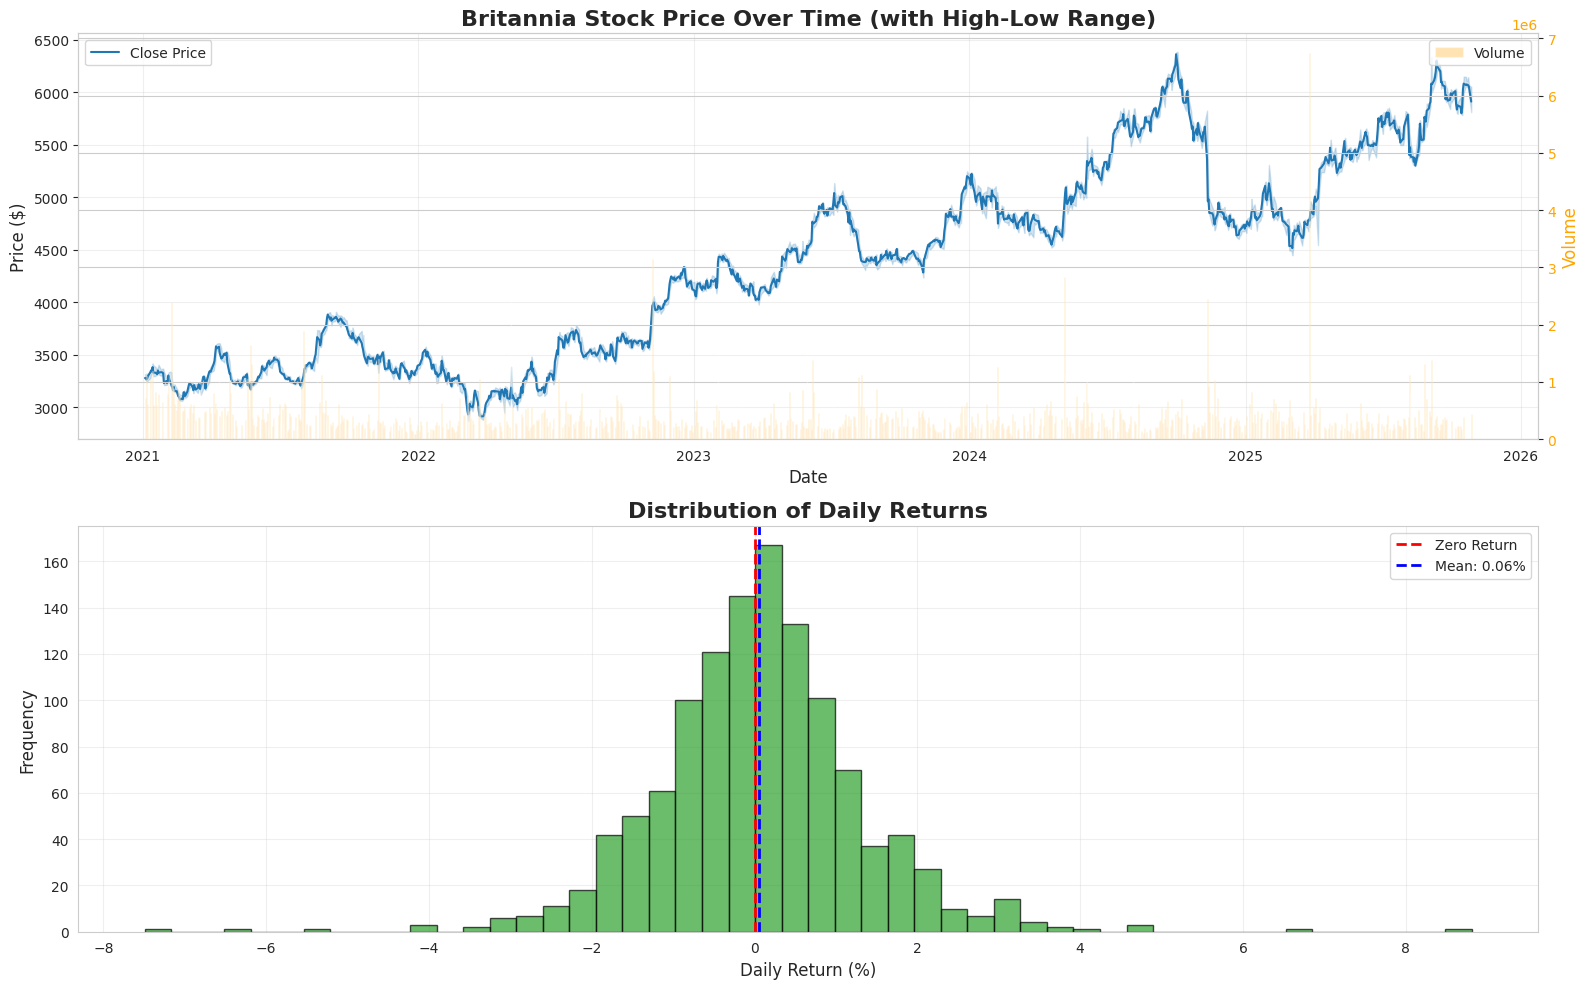

In [96]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(full['date'], full['Close'], color='#1f77b4', linewidth=1.5, label='Close Price')
axes[0].fill_between(full['date'], full['Low'], full['High'], alpha=0.2, color='#1f77b4')
axes[0].set_title('Britannia Stock Price Over Time (with High-Low Range)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot volume
ax2 = axes[0].twinx()
ax2.bar(full['date'], full['Volume'], alpha=0.3, color='orange', label='Volume')
ax2.set_ylabel('Volume', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

axes[1].hist(full['pct_change'].dropna(), bins=50, color='#2ca02c', alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
axes[1].axvline(full['pct_change'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {full["pct_change"].mean():.2f}%')
axes[1].set_title('Distribution of Daily Returns', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Daily Return (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

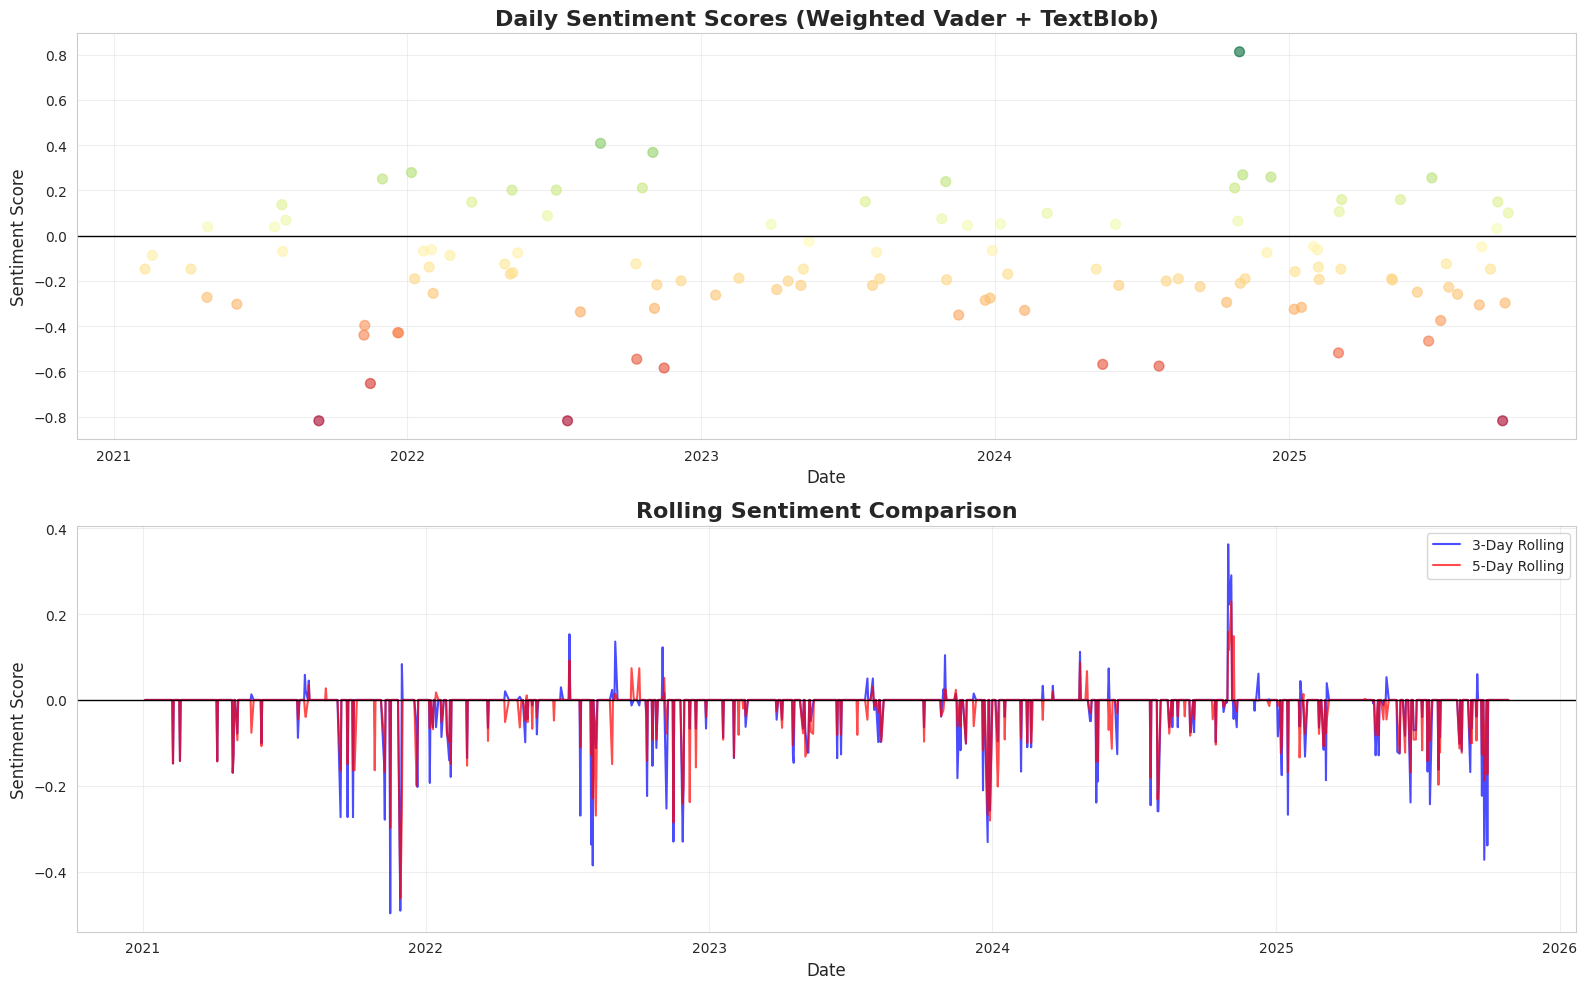

In [97]:
#@title Sentiment Analysis Over Time
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Raw sentiment
sent_plot_data = full[full['sentiment'] != 0]
axes[0].scatter(sent_plot_data['date'], sent_plot_data['sentiment'],
                c=sent_plot_data['sentiment'], cmap='RdYlGn', s=50, alpha=0.6)
axes[0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('Daily Sentiment Scores (Weighted Vader + TextBlob)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Sentiment Score', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Rolling sentiment comparison
if USE_3DAYS and USE_5DAYS:
    axes[1].plot(full['date'], full['sent_3d'], label='3-Day Rolling', color='blue', linewidth=1.5, alpha=0.7)
    axes[1].plot(full['date'], full['sent_5d'], label='5-Day Rolling', color='red', linewidth=1.5, alpha=0.7)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[1].set_title('Rolling Sentiment Comparison', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Sentiment Score', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
elif USE_3DAYS:
    axes[1].plot(full['date'], full['sent_3d'], label='3-Day Rolling', color='blue', linewidth=2)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[1].set_title('3-Day Rolling Sentiment', fontsize=16, fontweight='bold')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Enable rolling sentiment to see this plot',
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=14)

plt.tight_layout()
plt.show()

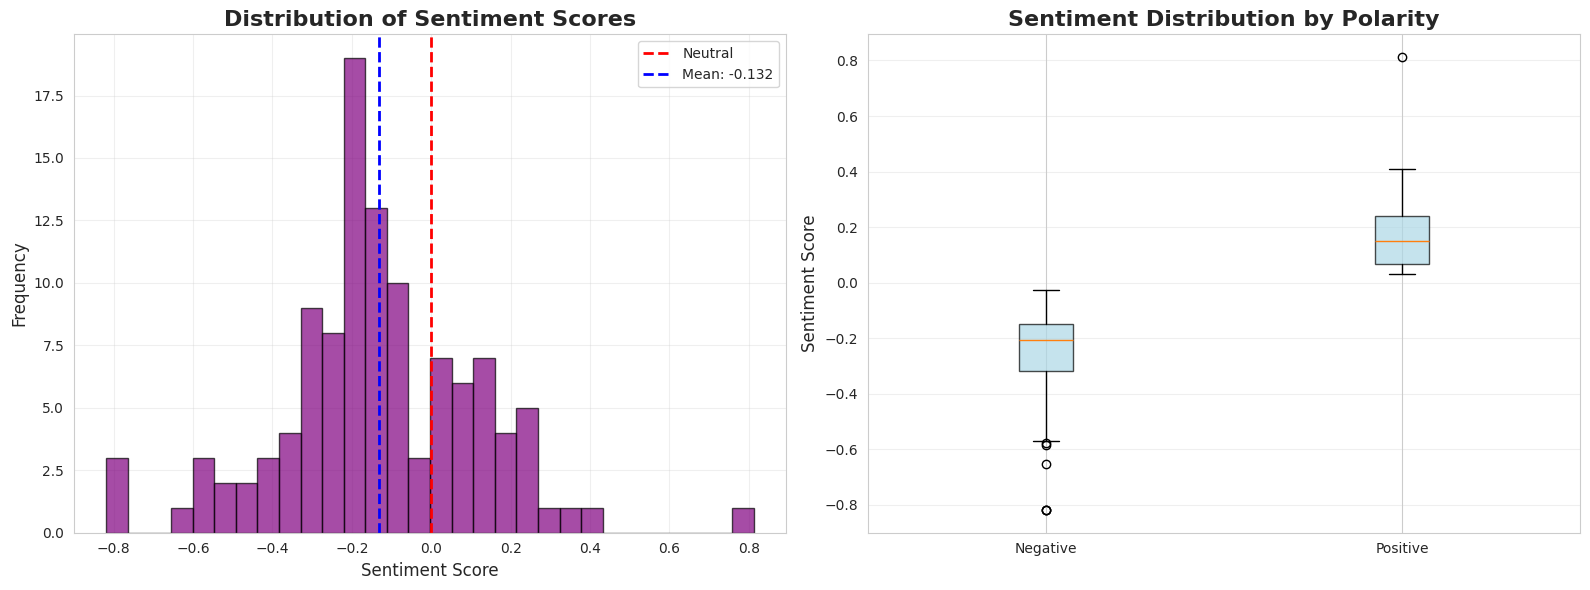

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(sent_data['sentiment'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral')
axes[0].axvline(sent_data['sentiment'].mean(), color='blue', linestyle='--',
                linewidth=2, label=f'Mean: {sent_data["sentiment"].mean():.3f}')
axes[0].set_title('Distribution of Sentiment Scores', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Sentiment Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
box_data = [sent_data[sent_data['sentiment'] < 0]['sentiment'],
            sent_data[sent_data['sentiment'] > 0]['sentiment']]
axes[1].boxplot(box_data, labels=['Negative', 'Positive'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_title('Sentiment Distribution by Polarity', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Sentiment Score', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

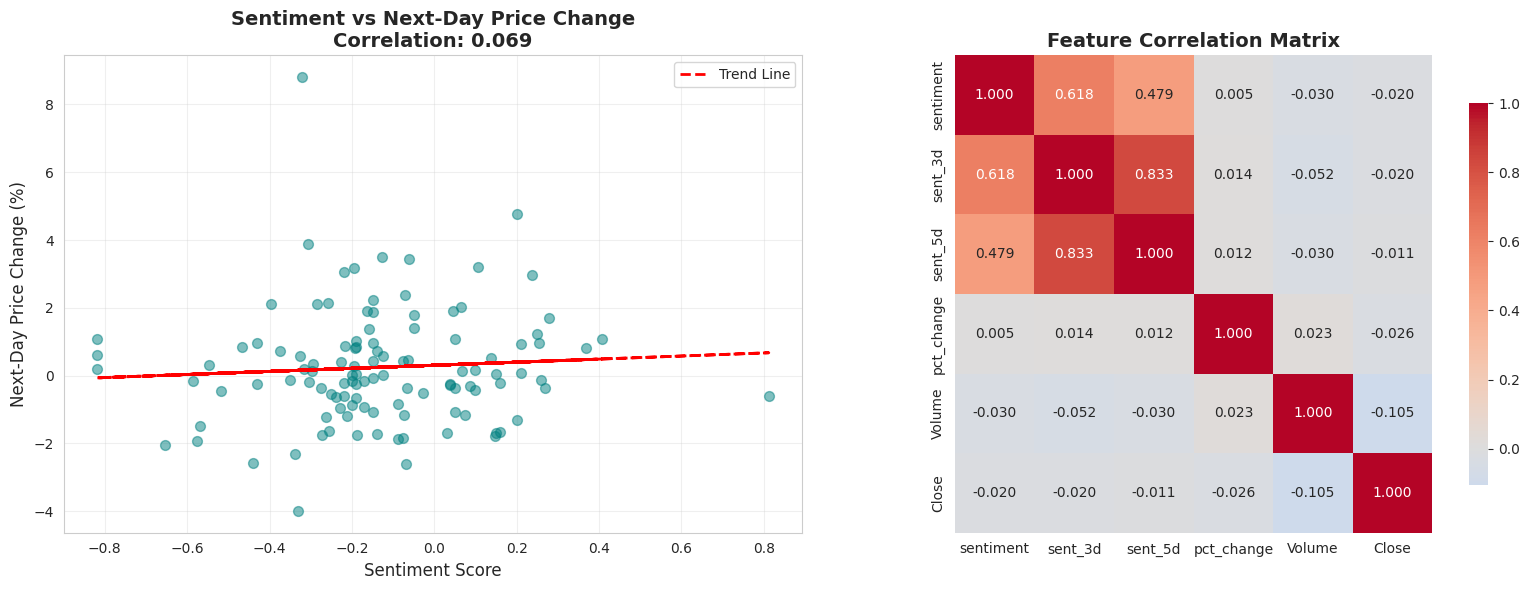

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment vs Price Change
sent_with_change = full[full['sentiment'] != 0][['sentiment', 'pct_change']].dropna()
axes[0].scatter(sent_with_change['sentiment'], sent_with_change['pct_change'],
                alpha=0.5, s=50, color='teal')
z = np.polyfit(sent_with_change['sentiment'], sent_with_change['pct_change'], 1)
p = np.poly1d(z)
axes[0].plot(sent_with_change['sentiment'], p(sent_with_change['sentiment']),
             "r--", linewidth=2, label=f'Trend Line')
correlation = sent_with_change['sentiment'].corr(sent_with_change['pct_change'])
axes[0].set_title(f'Sentiment vs Next-Day Price Change\nCorrelation: {correlation:.3f}',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Score', fontsize=12)
axes[0].set_ylabel('Next-Day Price Change (%)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Correlation heatmap
corr_cols = ['sentiment', 'pct_change', 'Volume', 'Close']
if USE_3DAYS: corr_cols.insert(1, 'sent_3d')
if USE_5DAYS: corr_cols.insert(2, 'sent_5d')
corr_matrix = full[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

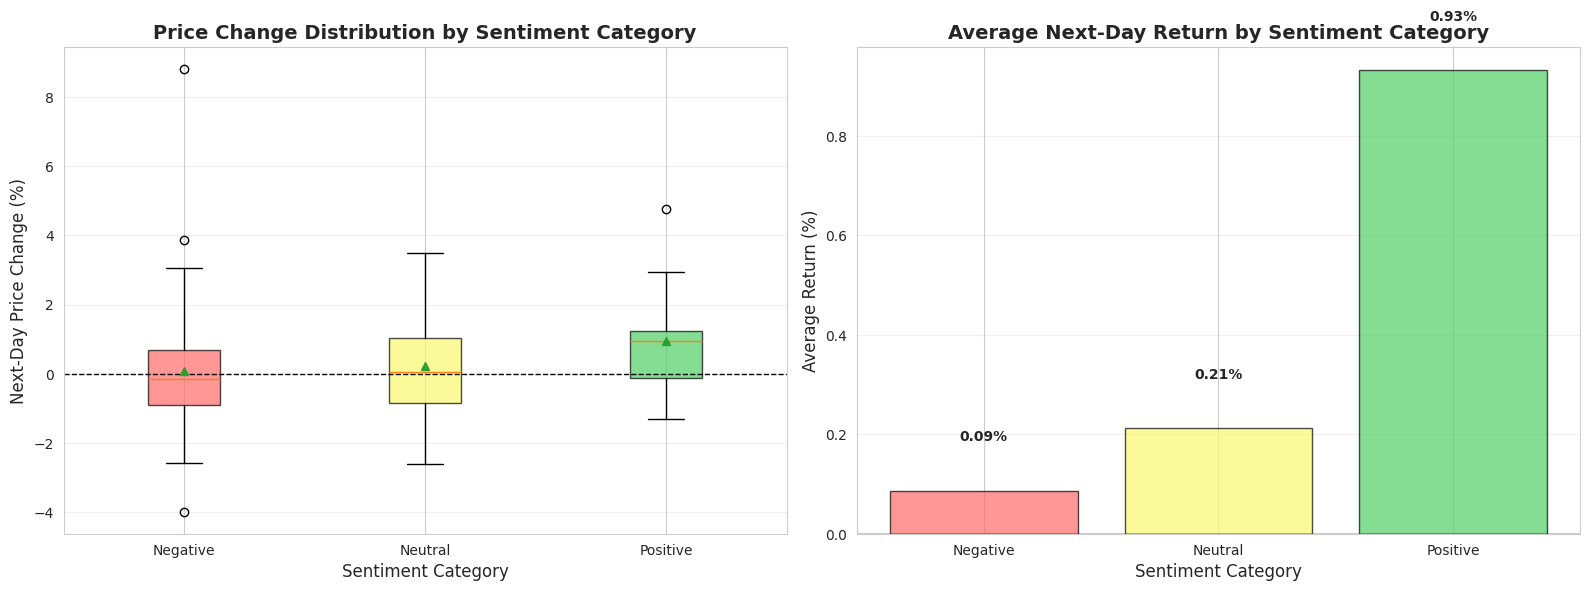

In [100]:
sentiment_categories = pd.cut(full[full['sentiment'] != 0]['sentiment'],
                               bins=[-np.inf, -0.2, 0.2, np.inf],
                               labels=['Negative', 'Neutral', 'Positive'])
full_categorized = full[full['sentiment'] != 0].copy()
full_categorized['sent_category'] = sentiment_categories

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot by category
category_data = [full_categorized[full_categorized['sent_category'] == cat]['pct_change'].dropna()
                 for cat in ['Negative', 'Neutral', 'Positive']]
bp = axes[0].boxplot(category_data, labels=['Negative', 'Neutral', 'Positive'],
                     patch_artist=True, showmeans=True)
colors = ['#ff6b6b', '#f9f871', '#51cf66']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_title('Price Change Distribution by Sentiment Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Category', fontsize=12)
axes[0].set_ylabel('Next-Day Price Change (%)', fontsize=12)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='y')

# Bar chart: Average returns
avg_returns = full_categorized.groupby('sent_category')['pct_change'].mean()
axes[1].bar(['Negative', 'Neutral', 'Positive'], avg_returns, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Average Next-Day Return by Sentiment Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment Category', fontsize=12)
axes[1].set_ylabel('Average Return (%)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(avg_returns):
    axes[1].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

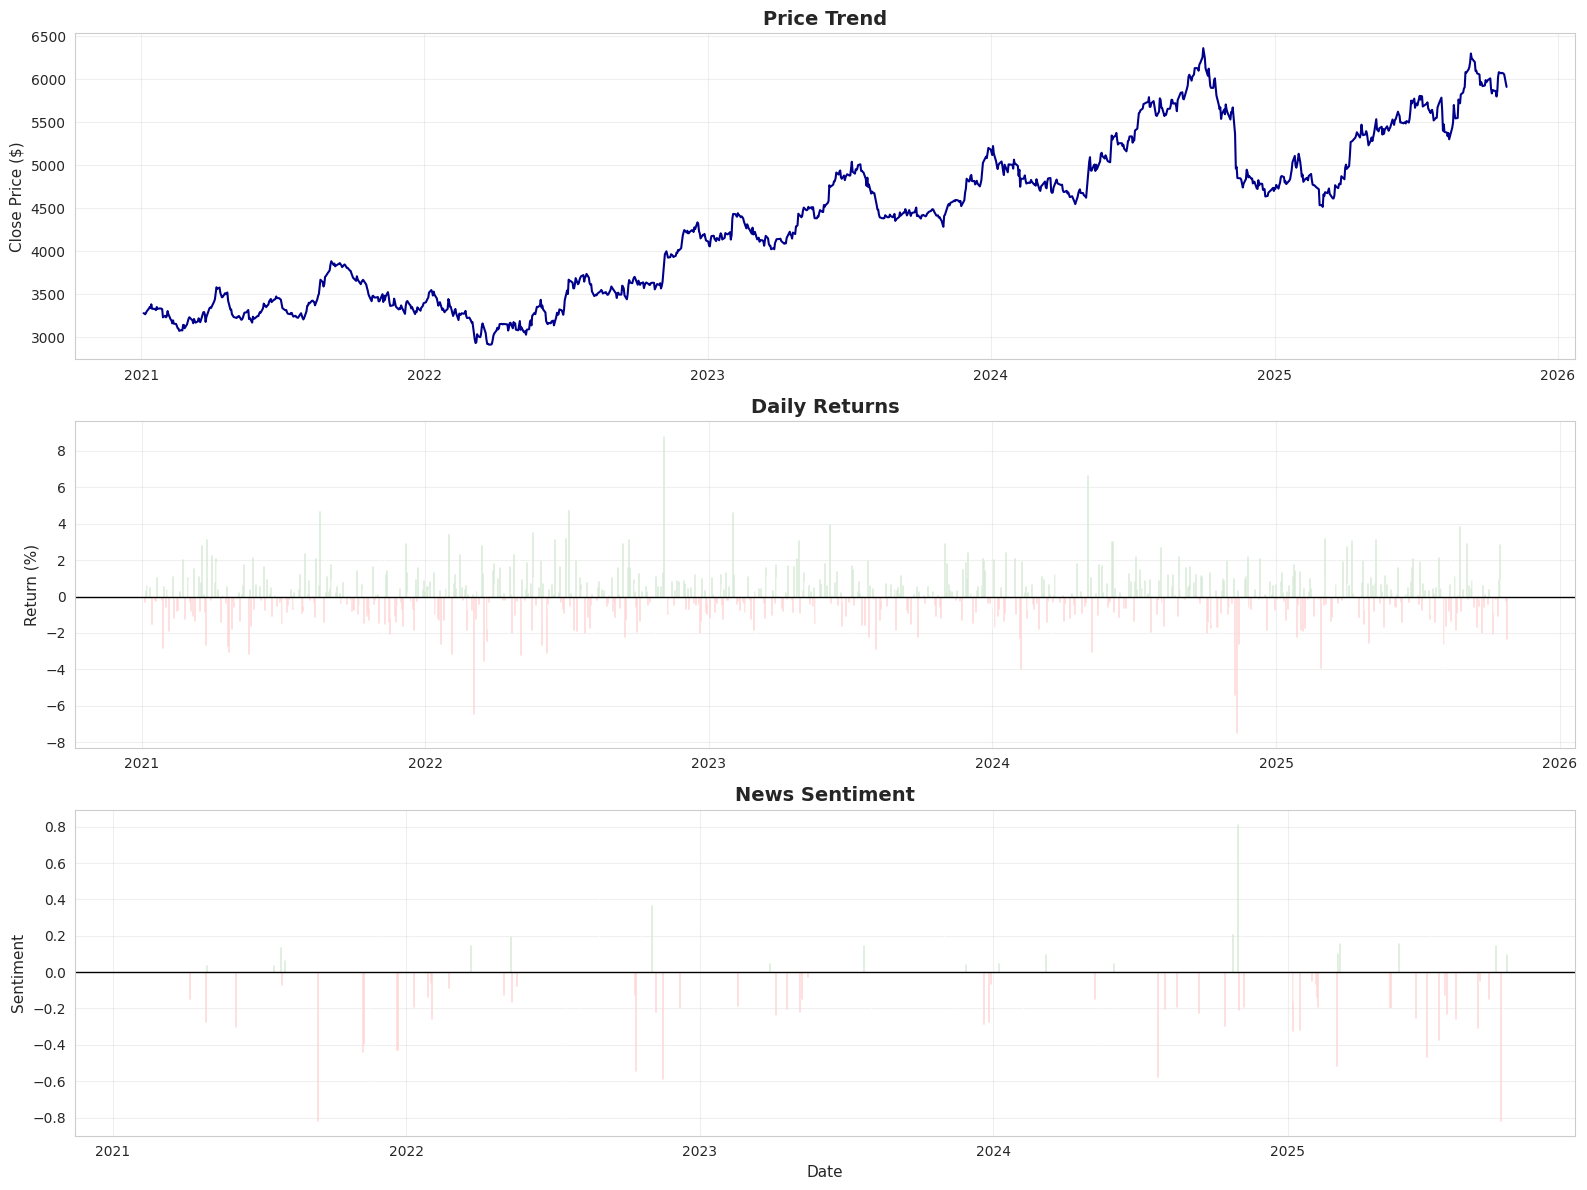

In [101]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Price trend
axes[0].plot(full['date'], full['Close'], color='darkblue', linewidth=1.5)
axes[0].set_title('Price Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Close Price ($)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Returns
axes[1].bar(full['date'], full['pct_change'],
            color=['green' if x > 0 else 'red' for x in full['pct_change']], alpha=0.6)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_title('Daily Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Return (%)', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Sentiment overlay
sent_plot = full[full['sentiment'] != 0]
axes[2].bar(sent_plot['date'], sent_plot['sentiment'],
            color=['green' if x > 0 else 'red' for x in sent_plot['sentiment']], alpha=0.6)
axes[2].axhline(0, color='black', linewidth=1)
axes[2].set_title('News Sentiment', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Sentiment', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [102]:
#@title Statistical Tests
print("5. STATISTICAL SIGNIFICANCE TESTS")
print("-"*80)

# T-test: Do positive vs negative sentiment days have different returns?
pos_sent_returns = full_categorized[full_categorized['sent_category'] == 'Positive']['pct_change'].dropna()
neg_sent_returns = full_categorized[full_categorized['sent_category'] == 'Negative']['pct_change'].dropna()

if len(pos_sent_returns) > 0 and len(neg_sent_returns) > 0:
    t_stat, p_value = stats.ttest_ind(pos_sent_returns, neg_sent_returns)
    print(f"T-test (Positive vs Negative Sentiment Returns):")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  Result: Statistically significant difference (p < 0.05)")
    else:
        print("  Result: No statistically significant difference (p >= 0.05)")
else:
    print("Not enough data for t-test")
print()

# Normality test for returns
_, p_norm = stats.normaltest(full['pct_change'].dropna())
print(f"Normality Test for Returns:")
print(f"  p-value: {p_norm:.4f}")
if p_norm < 0.05:
    print("  Result: Returns are NOT normally distributed (p < 0.05)")
else:
    print("  Result: Returns appear normally distributed (p >= 0.05)")
print()

5. STATISTICAL SIGNIFICANCE TESTS
--------------------------------------------------------------------------------
T-test (Positive vs Negative Sentiment Returns):
  t-statistic: 1.3844
  p-value: 0.1719
  Result: No statistically significant difference (p >= 0.05)

Normality Test for Returns:
  p-value: 0.0000
  Result: Returns are NOT normally distributed (p < 0.05)



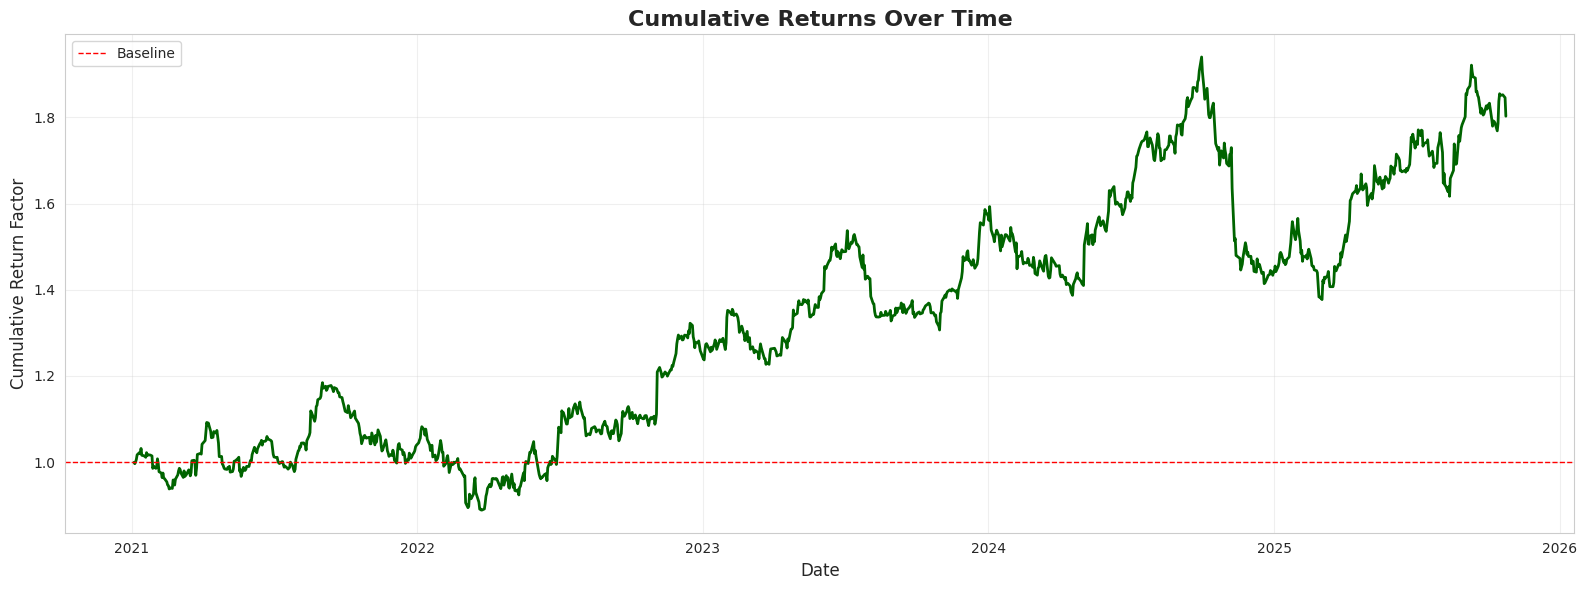

EDA COMPLETE!


In [103]:
#@title Cumulative Returns
full['cumulative_return'] = (1 + full['pct_change']/100).cumprod()
plt.figure(figsize=(16, 6))
plt.plot(full['date'], full['cumulative_return'], color='darkgreen', linewidth=2)
plt.axhline(1, color='red', linestyle='--', linewidth=1, label='Baseline')
plt.title('Cumulative Returns Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return Factor', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("="*80)
print("EDA COMPLETE!")
print("="*80)

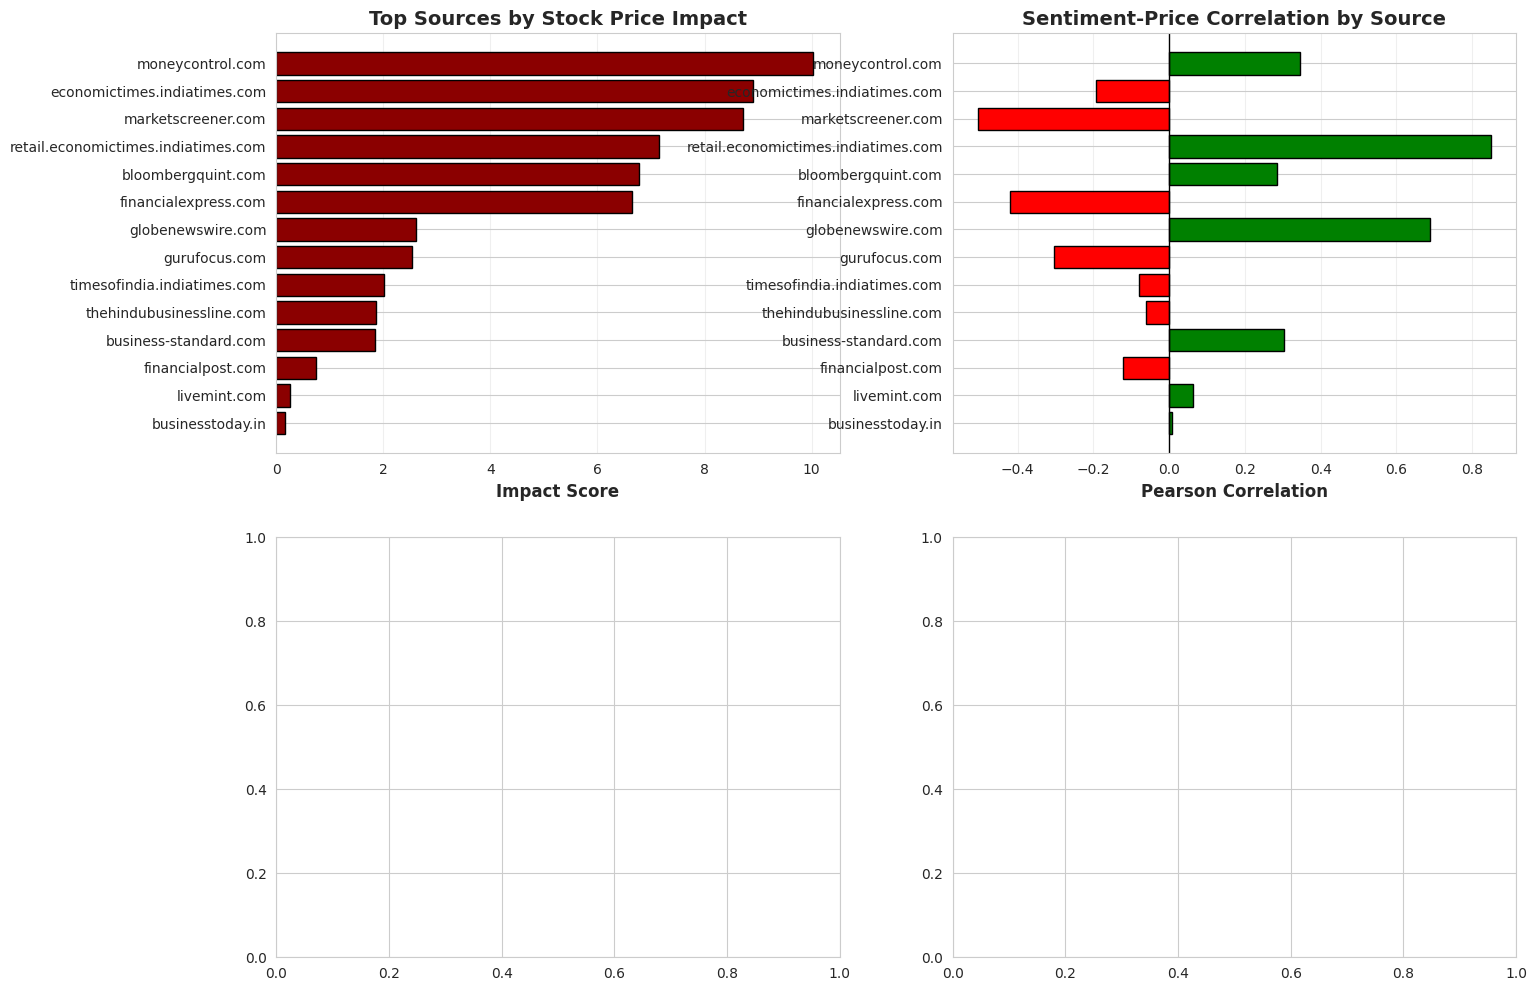

In [104]:
#@title Source Impact Analysis
# 1. Top Sources by Impact Score
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_n = min(15, len(impact_df))
top_sources = impact_df.head(top_n)

# Chart 1: Impact Score
axes[0,0].barh(range(top_n), top_sources['impact_score'], color='darkred', edgecolor='black')
axes[0,0].set_yticks(range(top_n))
axes[0,0].set_yticklabels(top_sources['source'])
axes[0,0].set_xlabel('Impact Score', fontsize=12, fontweight='bold')
axes[0,0].set_title('Top Sources by Stock Price Impact', fontsize=14, fontweight='bold')
axes[0,0].invert_yaxis()
axes[0,0].grid(axis='x', alpha=0.3)

# Chart 2: Correlation Strength
colors = ['green' if x > 0 else 'red' for x in top_sources['pearson_corr']]
axes[0,1].barh(range(top_n), top_sources['pearson_corr'], color=colors, edgecolor='black')
axes[0,1].set_yticks(range(top_n))
axes[0,1].set_yticklabels(top_sources['source'])
axes[0,1].set_xlabel('Pearson Correlation', fontsize=12, fontweight='bold')
axes[0,1].set_title('Sentiment-Price Correlation by Source', fontsize=14, fontweight='bold')
axes[0,1].axvline(x=0, color='black', linewidth=1)
axes[0,1].invert_yaxis()
axes[0,1].grid(axis='x', alpha=0.3)